# Homework 3 (100 points)

The goal of this homework is to practice techniques relating to SVD.

## Exercise 1 (65 points)

a) Fetch the "mnist_784" data and store is as a `.csv` (that way you don't have to fetch it every time - which takes about 30s). (4 points)

In [175]:
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
import pandas as pd
import numpy as np

X, y = fetch_openml(name="mnist_784", version=1, return_X_y=True, as_frame=False)

# Save the train_data(X) and train_label(y) set of "mnist_784" dataset
pd.DataFrame(X).to_csv("X.csv",header = None, index = None)
pd.DataFrame(y).to_csv("y.csv",header = None, index = None)

b) Plot the singular value plot for a single example of the 0 digit (5 points)

<function matplotlib.pyplot.show(close=None, block=None)>

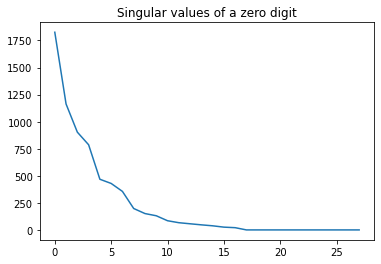

In [176]:
# Find the index of an example data record represents "0" digit
index_zero = np.where(y == "0")[0][0]
# Reshape the image to printable form
image = X[index_zero].reshape(28,28)
# Apply SVD on the example image
U, sigma, V = np.linalg.svd(image)
# Plot singular values
plt.plot(sigma.tolist())
plt.title("Singular values of a zero digit")
plt.show

c) By setting some singular values to 0, plot the approximation of the 0 digit next to the original digit. (5 points)

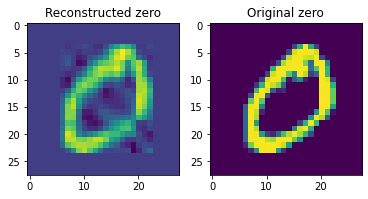

In [177]:
import random
# Set to 0 a specific number "num" of singular values
k = 5
sigma[k:] = 0
reconstructed_image = np.matrix(U[:, :]) * np.diag(sigma[:]) * np.matrix(V[:, :])

# Plot both reconstructed and original image
f, axarr = plt.subplots(1,2)
axarr[0].imshow(reconstructed_image)
axarr[0].title.set_text("Reconstructed zero")
axarr[1].imshow(image)
axarr[1].title.set_text("Original zero")


d) Consider the entire dataset as a matrix. Perform SVD and store the dataset approximation in a new `.csv` file. Explain why / how you chose a particular rank. (10 points)

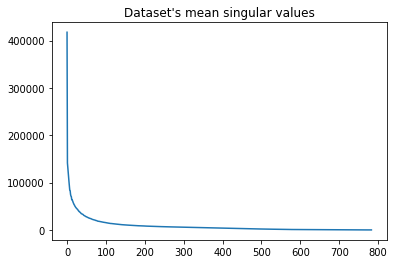

In [178]:
# Apply SVD on the whole dataset
U, sigma, V = np.linalg.svd(X,full_matrices=False)
# Plot original singular values to justify my choice of 100 as the rank.
plt.plot(sigma.tolist())
plt.title("Dataset's mean singular values")
plt.show
# Reconstruct the image with a rank-k approximation of image 
k = 100
sigma[k:] = 0
reconstructed_dataset = np.matrix(U[:, :]) * np.diag(sigma[:]) * np.matrix(V[:, :]) 

The reason I choose the 100th rank is the following:
As we can see from the above plot, the approximate first 100 ranks hold the higher values increasing the variance of our dataset, while the rest holds least significant information so we can withdraw them. 

e) As in homework 2, using Kmeans on this new dataset, cluster the images from d) using 10 clusters and plot the centroid of each cluster. (10 points)

/Users/krithman/.pyenv/versions/3.9.6/lib/python3.9/site-packages/sklearn/utils/validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


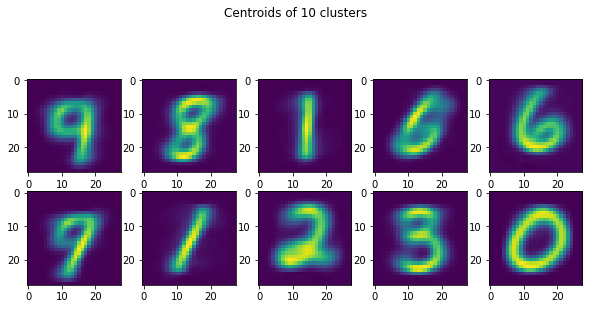

In [179]:
from sklearn.cluster import KMeans

def plot_KMeans_centroids(dataset):
    # Initialize the K-Means model
    kmeans = KMeans(n_clusters = 10)
    # Fitting the model to image set
    kmeans.fit(dataset)
    # Get centroids and nullify the normalization effect 
    centroids = kmeans.cluster_centers_
    # Reshape to turn the centroids into 
    # a 2D representation form for visualization
    centroids = centroids.reshape(10,28,28)

    # Start ploting
    fig = plt.figure(figsize = (10,10))
    fig.suptitle('Centroids of 10 clusters')
    for i in range(10):
        plt.subplot(5,5,i+1)
        plt.imshow(centroids[i])
    
    return kmeans

kmeans_approximation = plot_KMeans_centroids(reconstructed_dataset)

f) Repeat e) on the original dataset. Comment on any differences (or lack thereof) you observe. (8 points)

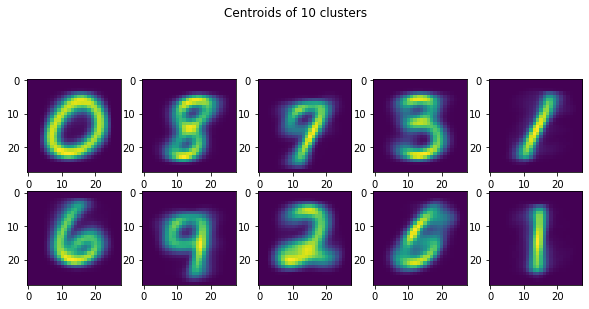

In [180]:
kmeans_original = plot_KMeans_centroids(X)

As we can see in the below code cell, the sum of squared instance are quite similar, which is a quick indicator that the clusterings of both the original and approximation dataset are similar. It is obvious that removing the less informative ranks and keeping only the 10 with the highest variance, keeps the dataset almost the same and as a result the KMeans centroids too. 

In [181]:
print("Original dataset:\nSum of squared instances of samples to their cluster center " + str(kmeans_original.inertia_))
print("Approximation dataset:\nSum of squared instances of samples to their cluster center " + str(kmeans_approximation.inertia_))

Original dataset:
Sum of squared instances of samples to their cluster center 178432702636.28412
Approximation dataset:
Sum of squared instances of samples to their cluster center 158023106794.8682


g) Compare the disagreement distance of the clustering obtained in e) to the true labels, to the disagreement distance of the clustering obtained in f) to the true labels. Comment briefly. (8 points)

In [182]:
def disagreement_dist(P_labels, C_labels):
    df = pd.DataFrame({'label_P':P_labels, 'label_C':C_labels})
    disagreement_distance_P = 0
    disagreement_distance_C = 0
    # For each digit of P_labels filter the column with one digit at a time and 
    # take value_counts on each digit of the C_labels and do all possible combinations on C_labels. 
    for digit in range(np.unique(P_labels).shape[0]):
        disagreement_distance_P += calculate_combinations(df[df.label_C == digit]['label_P'].value_counts().tolist())
    # For each digit of C_labels filter the column with one digit at a time and 
    # take value_counts on each digit of the P_labels and do all possible combinations on P_labels. 
    for digit in range(np.unique(C_labels).shape[0]):
        disagreement_distance_C += calculate_combinations(df[df.label_P == digit]['label_C'].value_counts().tolist())
    disagreement_distance = disagreement_distance_P + disagreement_distance_C
    return disagreement_distance

# Compute all possible combinations between two columns
def calculate_combinations(x):
    disagreement_distance = 0
    for i in range(len(x)):
        for j in range(len(x)):
            if i<j:
                disagreement_distance += x[i]*x[j]
    return disagreement_distance
    
# True labels
P_labels = y.astype(np.int32)
# Disagreement distance between true labels and clustering obtained in e)
C_labels = kmeans_approximation.labels_
print("Disaggrement distance between true labels and clustering obtained in e) is: {}".format(disagreement_dist(P_labels,C_labels)))
# Disagreement distance between true labels and clustering obtained in f)
C_labels = kmeans_original.labels_
print("Disaggrement distance between true labels and clustering obtained in f) is: {}".format(disagreement_dist(P_labels,C_labels)))


Disaggrement distance between true labels and clustering obtained in e) is: 289492959
Disaggrement distance between true labels and clustering obtained in f) is: 288671375


The values are really close and the reason is that on the approximation dataset we removed the ranks with the lowest variance (the less informative data) so by keeping only the 10 most informative (as figure I plotted below 1(d)) we should have similar results with the clustering comparisons.

h) Create a matrix that is the difference between the original dataset and the rank-10 approximation of the dataset. (10 points)

In [183]:
# Apply SVD on the whole dataset
U, sigma, V = np.linalg.svd(X,full_matrices=False)
# Reconstruct the image with a rank-10 approximation of image 
k = 10
sigma[k:] = 0
reconstructed_dataset = np.matrix(U[:, :]) * np.diag(sigma[:]) * np.matrix(V[:, :]) 
# Numpy element wise subtraction between original dataset and rank-10 approximation of the dataset
X_diff = X - reconstructed_dataset

i) The largest (using euclidean distance from the origin) rows of the matrix could be considered anomalous data points. Briefly explain why. Plot the 10 images responsible for the 10 largest rows. (5 points)

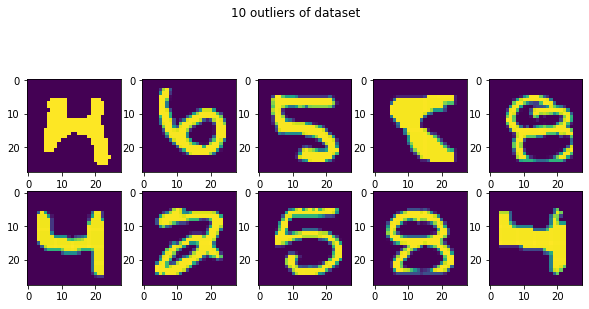

In [190]:
# Calculate,sort & find the 10 largest euclidean distances on X from the origin
euclid_distance = np.linalg.norm(X_diff,axis=1)
sort_euclid_distance = np.sort(euclid_distance)[::-1][:10]

# Start ploting
fig = plt.figure(figsize = (10,10))
fig.suptitle('10 outliers of dataset')
for i in range(10):
    # Find the indexes of the 10 largest euclidean distances
    image_index = np.where(euclid_distance == sort_euclid_distance[i])
    # Reshape the image from (784,) to (28,28) on approximation dataset
    image = X[image_index].reshape(28,28)
    plt.subplot(5,5,i+1)
    plt.imshow(image)


The higher the euclidean distance between a data point(in this case a image) of the X_diff matrix the higher is the difference between original dataset and the approximation one. That means that by picking the 10 largest values you are going to choose the most probable anomalous data points which do not approach the original dataset as well as the rest data points.That's why it is hard for us to categorize those images to a specific digit. In this case we see digits, which could be either 2 or 8 or 5.  

## Exercise 2 (35 points)

a) Modify the code below to pick 4 categories of news articles that you think are minimally related (for example `sci.space` and `rec.sport.baseball`). (3 points)

In [185]:
import numpy as np
import nltk
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.snowball import SnowballStemmer
import pandas as pd 

categories = [ 'sci.crypt','sci.electronics','sci.med','sci.space']
news_data = fetch_20newsgroups(subset='train', categories=categories)

b) Using the `SnowballStemmer`, stem the words in every article (10 points)

In [186]:
corpus = []
stemmer = SnowballStemmer(language='english')
for article in news_data.data:
    corpus.append(stemmer.stem(article))

c) Use the `TfidfVectorizer` on the stemmed articles. Set `min_df` and `max_df` to reasonable numbers and briefly explain your reasoning. Store the resulting dataset into a `.csv` file. (7 points)

In [187]:
vectorizer = TfidfVectorizer(min_df=0.1,max_df= 0.9)
dataset = vectorizer.fit_transform(corpus)
dataset_tokens = vectorizer.get_feature_names_out()
df_countvect = pd.DataFrame(data = dataset.toarray(),columns = dataset_tokens)
df_countvect.to_csv("tdidf_dataset.csv", encoding='utf-8', index=False)

The choice of min_df and max_df was taken for the following reasons:
1) For min_df=0.1, I wanted to remove words who rarely appear in all the articles.
2) For min_df=0.9, I wanted to remove words who always appear in all the articles.
3) The choices of those limits (0.1 & 0.9) were selected since they produce a fairly sized corpus to work with.

d) For rank k ranging from 1 to 25:

1. Reduce the dimensionality of the tfidf vectorized data using a dimension reduction technique discussed in class.
2. Apply Kmeans on the reduced dataset to create 4 clusters
3. Record the disagreement distance between the clustering in 2 and the article category

Then plot the recorded disagreement distance per rank. Comment briefly. (15 points)

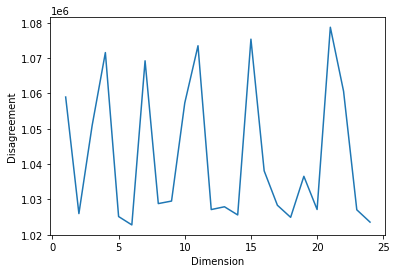

In [189]:
from sklearn.decomposition import PCA

disagreement_distance = []
for k in range(1,25):
    # Apply PCA dimentionallity reduction technique with number of components equal to the index of for loop.
    pca = PCA(n_components=k)
    dim_reduced_dataset = pca.fit_transform(df_countvect)
    kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=100, n_init=10, random_state=0)
    kmeans.fit_predict(dim_reduced_dataset)
    labelsk = kmeans.labels_
    disagreement_distance.append(disagreement_dist(labelsk, news_data.target))

plt.plot(range(1,25), disagreement_distance)
plt.ylabel('Disagreement')
plt.xlabel('Dimension')
plt.show()

As we can see through the plot, there are multiple choices of rank with the lowest disagreement distance, but if we want to reduce the dimensions while keeping the distance low then a choice of rank as 6 could work. It is important to notice that the plot changes with different categories.